In [1]:
import numpy as np
import os

Se cambiaron las arquitecturas de las redes neuronales, para darles otra capa de convolución. Se jugo con el numero de capas, el tamaño de filtro. La mejor arquitectura fue la actual. También se cambio el optimizador del discriminador por rmsprop, ya que mostró mejores resultados. Además, se modificó el learning rate del clasificador, haciéndolo un poco mas lento y el del generador, se hizo mas rápido. No se tuvo una arquitectura donde ambas redes neuronales, tuvieran un accuracy alto, sin embargo, en esta arquitectura, los valores fueron los menos distantes. También se puede ver que los valores de perdida, se estabilizaron y convergieron, de forma que la red del generador logro aprender y tener una perdida baja. En el accuracy, también se puede ver que estuvieron teniendo cruces. Normalmente lo que se busca, según la literatura, es que converjan los valores, para poder generar mejores resultados. Las imágenes muestran que los resultados fueron positivos.

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from keras.models import Model
from keras.layers import Input,Dense,Conv2D,Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Conv2DTranspose,UpSampling2D
#from keras.optimizers import RMSprop

2.7.0


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
input_images="full_numpy_bitmap_apple.npy"
data=np.load(input_images)

In [5]:
np.shape(data)

(144722, 784)

In [6]:
data=data/255
data=np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h=data.shape[1:3]

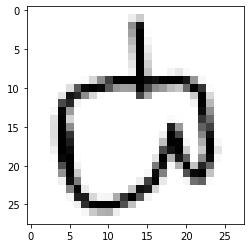

In [7]:
plt.imshow(data[4242,:,:,0],cmap='Greys')

In [8]:
def build_discriminator(depth=64,p=0.4):
    image=Input((img_w,img_h,1))
    
    conv1=Conv2D(depth*1,5,strides=2,padding='same',activation='relu')(image)
    conv1=Dropout(p)(conv1)
    conv1=MaxPooling2D()(conv1)
    conv2=Conv2D(depth*2,5,strides=2,padding='same',activation='relu')(conv1)
    conv2=Dropout(p)(conv2)
    #conv2=MaxPoling2D()(conv2)
    conv3=Conv2D(depth*4,5,strides=2,padding='same',activation='relu')(conv2)
    conv3=Dropout(p)(conv3)
    
    conv4=Conv2D(depth*8,5,strides=1,padding='same',activation='relu')(conv3)
    #conv4=Flatten()(Dropout(p)(conv4))
    conv5=Conv2D(depth*10,5,strides=1,padding='same',activation='relu')(conv4)
    conv5=Flatten()(Dropout(p)(conv5))
    fullcon = Dense(100,activation='relu')(conv5)
    prediction=Dense(1,activation='sigmoid')(fullcon)
    
    model=Model(inputs=image,outputs=prediction)
    
    return model

In [9]:
discriminator=build_discriminator()

In [ ]:
#discriminator.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0008,decay=6e-8,clipvalue=1.0),metrics=['accuracy'])

In [10]:
#from keras.optimizers import Adam 
import tensorflow as tf
discriminator.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(lr=0.0001,decay=6e-8,clipvalue=1.0),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Arquitectura del modelo Generador

In [11]:
z_dimensions=32
from keras.layers import LeakyReLU

def build_generator(latent_dim=z_dimensions,depth=64,p=0.3):
    noise=Input((latent_dim,))
    
    dense1=Dense(7*7*depth)(noise)
    dense1=BatchNormalization(momentum=0.9)(dense1)
    dense1=Activation(activation='relu')(dense1)
    dense1=Reshape((7,7,depth))(dense1)
    dense1=Dropout(p)(dense1)
    
    conv1=UpSampling2D()(dense1)
    conv1=Conv2DTranspose(int(depth/2),kernel_size=5,padding='same',activation=None,)(conv1)
    conv1=BatchNormalization(momentum=0.9)(conv1)
    conv1=Activation(activation='relu')(conv1)
    #conv1=MaxPooling2D()(conv1)
    conv2=UpSampling2D()(conv1)
    conv2=Conv2DTranspose(int(depth/4),kernel_size=5,padding='same',activation=None,)(conv2)
    conv2=BatchNormalization(momentum=0.9)(conv2)
    conv2=Activation(activation='relu')(conv2)
    #conv2=MaxPooling2D()(conv2)
    conv3=Conv2DTranspose(int(depth/8),kernel_size=5,padding='same',activation=None,)(conv2)
    conv3=BatchNormalization(momentum=0.9)(conv3)
    conv3=Activation(activation='relu')(conv3)
    #conv3=MaxPooling2D()(conv3)
    conv4=Conv2DTranspose(int(depth/16),kernel_size=5,padding='same',activation=None,)(conv3)
    conv4=BatchNormalization(momentum=0.9)(conv4)
    conv4=Activation(activation='relu')(conv4)
    #conv4=MaxPooling2D()(conv4)
    image=Conv2D(1,kernel_size=5,padding='same',activation='sigmoid')(conv4)
    
    model=Model(inputs=noise,outputs=image)
    return model
    
    
    

In [12]:
generator=build_generator()

In [13]:
z=Input(shape=(z_dimensions,))
img=generator(z)
discriminator.trainable=False
pred=discriminator(img)
adversarial_model=Model(z,pred)

In [19]:
adversarial_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(lr=0.001,decay=2e-8,clipvalue=1.0),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    d_metrics = []
    a_metrics = []
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        # sample real images: 
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],
            (batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0,size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # train discriminator: 
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0, 1.0,size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # train adversarial net: 
        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # periodically print progress & fake images: 
        if (i+1)%100 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics


Epoch #99
99: [D loss: 0.391128, acc: 0.843079]  [A loss: 3.540247, acc: 0.146307]


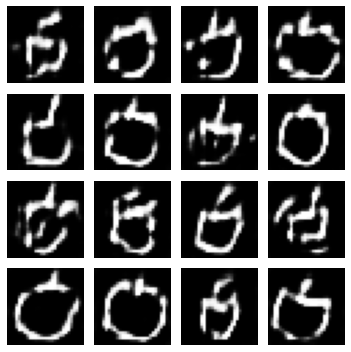

Epoch #199
199: [D loss: 0.533128, acc: 0.714274]  [A loss: 2.207522, acc: 0.219496]


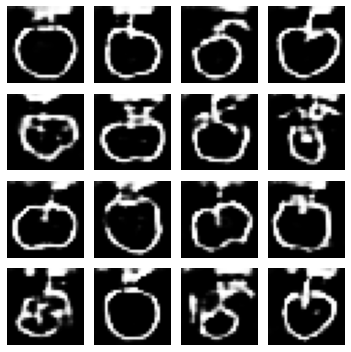

Epoch #299
299: [D loss: 0.581465, acc: 0.666323]  [A loss: 1.730108, acc: 0.258152]


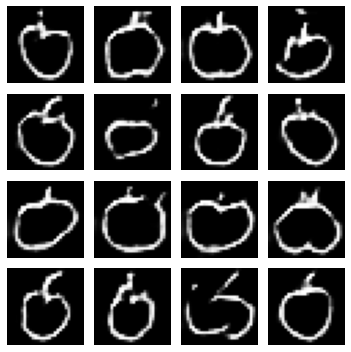

Epoch #399
399: [D loss: 0.605621, acc: 0.643033]  [A loss: 1.490050, acc: 0.278411]


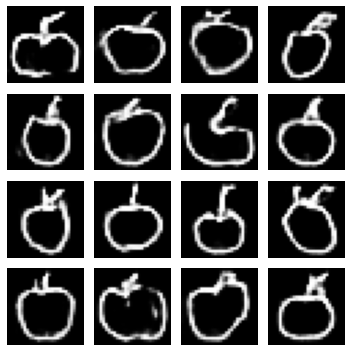

Epoch #499
499: [D loss: 0.619977, acc: 0.628280]  [A loss: 1.344983, acc: 0.296765]


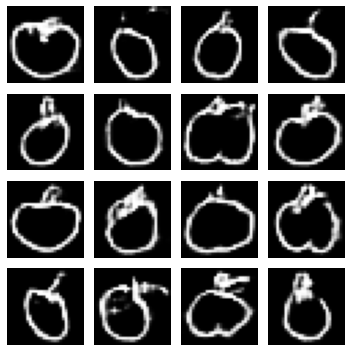

Epoch #599
599: [D loss: 0.629456, acc: 0.618440]  [A loss: 1.249302, acc: 0.308183]


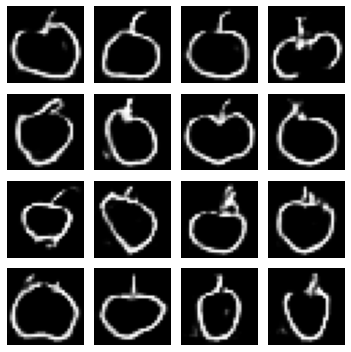

Epoch #699
699: [D loss: 0.636044, acc: 0.612102]  [A loss: 1.181524, acc: 0.315071]


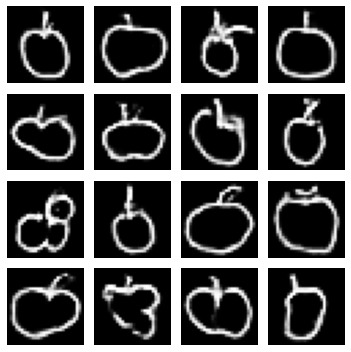

Epoch #799
799: [D loss: 0.640959, acc: 0.607092]  [A loss: 1.130292, acc: 0.320401]


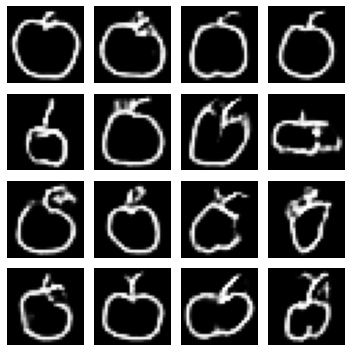

Epoch #899
899: [D loss: 0.644577, acc: 0.603905]  [A loss: 1.090182, acc: 0.326934]


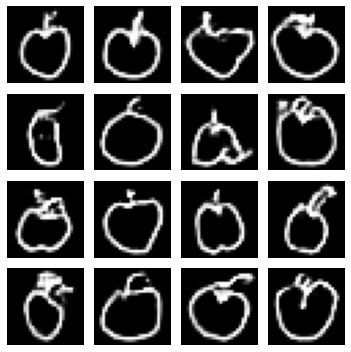

Epoch #999
999: [D loss: 0.647406, acc: 0.601664]  [A loss: 1.058931, acc: 0.332145]


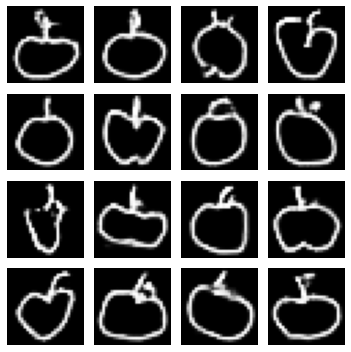

Epoch #1099
1099: [D loss: 0.649914, acc: 0.599178]  [A loss: 1.033118, acc: 0.336805]


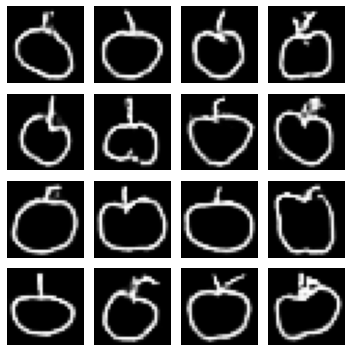

Epoch #1199
1199: [D loss: 0.651484, acc: 0.597819]  [A loss: 1.012335, acc: 0.339658]


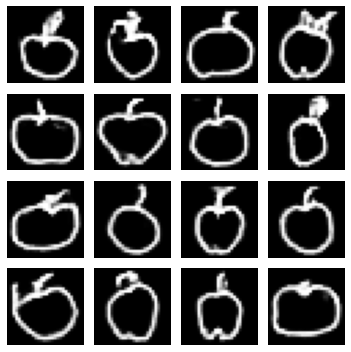

Epoch #1299
1299: [D loss: 0.652649, acc: 0.597187]  [A loss: 0.995769, acc: 0.341970]


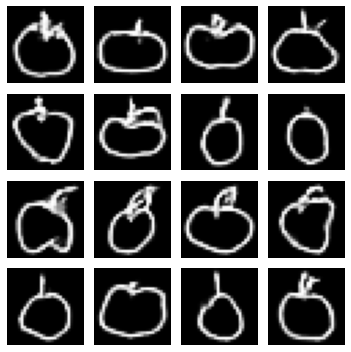

Epoch #1399
1399: [D loss: 0.653823, acc: 0.596380]  [A loss: 0.981166, acc: 0.343253]


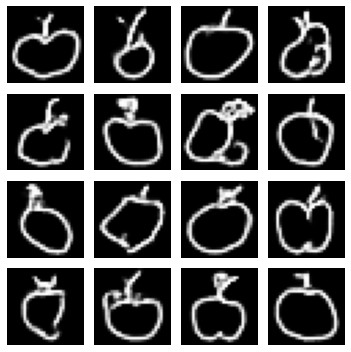

Epoch #1499
1499: [D loss: 0.654556, acc: 0.596332]  [A loss: 0.968992, acc: 0.345074]


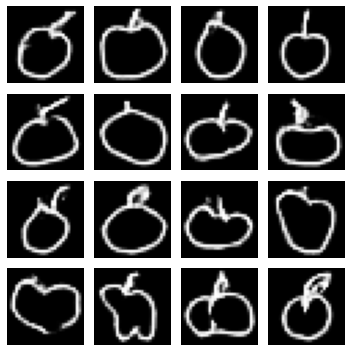

Epoch #1599
1599: [D loss: 0.655147, acc: 0.596344]  [A loss: 0.958785, acc: 0.346330]


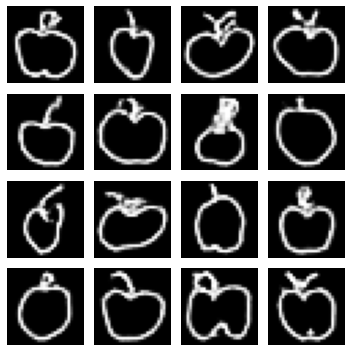

Epoch #1699
1699: [D loss: 0.655677, acc: 0.596182]  [A loss: 0.949320, acc: 0.347907]


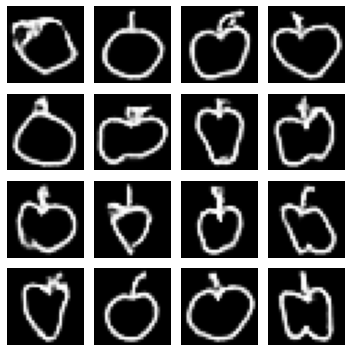

Epoch #1799
1799: [D loss: 0.655864, acc: 0.596612]  [A loss: 0.941999, acc: 0.349126]


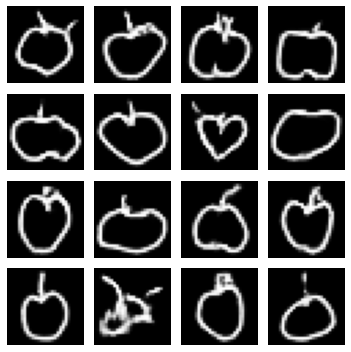

Epoch #1899
1899: [D loss: 0.656101, acc: 0.596731]  [A loss: 0.935550, acc: 0.349810]


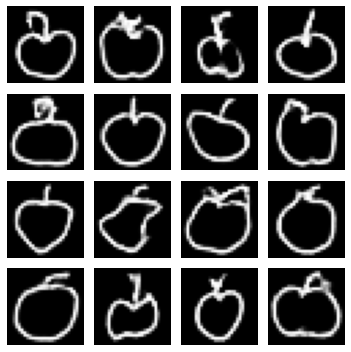

Epoch #1999
1999: [D loss: 0.656252, acc: 0.597043]  [A loss: 0.929761, acc: 0.350175]


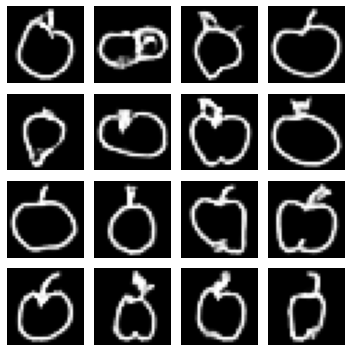

In [21]:
a_metrics_complete, d_metrics_complete = train()


Text(0, 0.5, 'Loss')

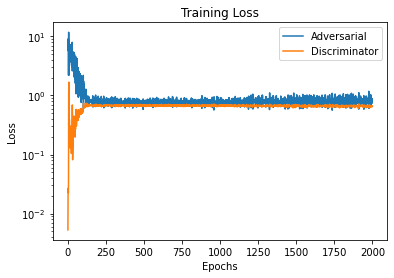

In [22]:

ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

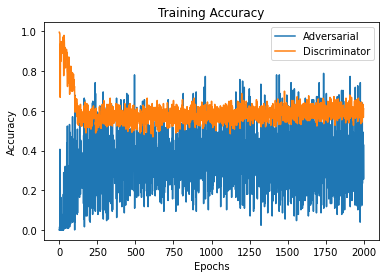

In [23]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")